In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import gwsurrogate
import scri
import h5py
from astropy import constants as const
from scipy.interpolate import CubicSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel
import os
from shutil import copyfile
import fileinput
import seaborn as sns
## if you need the surrogate data: 
##gwsurrogate.catalog.pull('NRSur7dq4')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

Populating the interactive namespace from numpy and matplotlib


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


### Helper functions

In [3]:
## Helper functions
def Ramp(time, t_s, t_r):
    """ Ramp function for tapering the waveform"""
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    
def swsh(s, modes, theta, phi, psi=0):
    """
    Return a value of a spin-weighted spherical harmonic of spin-weight s. 
    If passed a list of several modes, then a numpy array is returned with 
    SWSH values of each mode for the given point.
    For one mode:       swsh(s,[(l,m)],theta,phi,psi=0)
    For several modes:  swsh(s,[(l1,m1),(l2,m2),(l3,m3),...],theta,phi,psi=0)
    """
    import spherical_functions as sf
    import quaternion as qt
    return sf.SWSH(qt.from_spherical_coords(theta, phi), s, modes) * np.exp(1j * s * psi)



### Extrapolate the waveforms that we're interested in

In [ ]:
# ## Extrapolate the waveforms
# scri.extrapolate(
#     InputDirectory = 'Waveforms/Lev1',
#     OutputDirectory = 'Waveforms/Lev1',
#     DataFile = 'rh_FiniteRadii_CodeUnits.h5',
#     ChMass = 1.000044463203, 
#     UseStupidNRARFormat = True, 
# )
# scri.extrapolate(
#     InputDirectory = 'Waveforms/Lev2',
#     OutputDirectory = 'Waveforms/Lev2',
#     DataFile = 'rh_FiniteRadii_CodeUnits.h5',
#     ChMass = 1.0000147234369998, 
#     UseStupidNRARFormat = True, 
# )
# scri.extrapolate(
#     InputDirectory = 'Waveforms/Lev3',
#     OutputDirectory = 'Waveforms/Lev3',
#     DataFile = 'rh_FiniteRadii_CodeUnits.h5',
#     ChMass = 1.000000289914, 
#     UseStupidNRARFormat = True, 
# )

### Read in the extrapolated waveforms

In [4]:
## Read in the extrapolated modes
def ReadExtrapolatedModes(file, mass_msun, dist_kpc, theta, phi, dt, interpolate = True):
    """ 
        File is the file containing the extrapolated waveform that we want to read in 
        mass_msun is the total mass of the system in solar masses, and 
        dist_kpc is the distance to the system in kpc. 
        theta and phi are angles determining the inclination.
        dt is the timestep (reciprocal of the sampling rate)
        
        If we want to interpolate the waveform to have even timesteps dt, then 
        set interpolate to True. Otherwise, we'll return the data without 
        performing the interpolation """

    ## Read in the data
    f = h5py.File(file, 'r')
    
    ## grab the length of the waveform first
    data = f['Extrapolated_N2.dir']['Y_l2_m2.dat']
    time = np.array(data[:,0])
    
    h_plus = np.zeros(len(time))
    h_cross = np.zeros(len(time))
    
    modes = [(2, -2), (2,2)]
    #modes = [(l,m) for l in range(2,5) for m in range(-l, l+1)]
    for mode in modes: 
        
        ## Grab the mode in question
        #print('Computing for ', mode)
        l = mode[0]
        m = mode[1]
        
        data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m' + str(m) + '.dat']
        real = np.array(data[:,1])
        imag = np.array(data[:,2])
        coeff = real + 1j * imag
        
        ## Multiply by the corresponding spin-weighted spherical harmonic
        Ylm = swsh(-2, [(l,m)], theta=theta, phi=phi, psi=0) 
        h = coeff * Ylm 
        
        ## Add to our h_plus and h_cross computations
        h_plus = h_plus + np.real(h)
        h_cross = h_cross - np.imag(h) 
        
        
    ## Apply the astrophysical parameters
    time = time*mass_msun*const.G/(const.c**3)
    h_plus = h_plus*const.G*mass_msun/((const.c)**2*dist_kpc)
    h_cross = h_cross*const.G*mass_msun/((const.c)**2*dist_kpc)

    ## Taper the waveform and apply the ramp (need to start the waveform at zero for this)
    time = time - time[0]
    ramp = np.array([Ramp(t.value, 0.1, 0.3) for t in time])
    
    h_plus = h_plus * ramp
    h_cross = h_cross * ramp
    
    ## Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]
    
    if not interpolate:
        print("Not performing the interpolation")
        return time, h_plus, h_cross
    
    ## Now build the interpolants 
    cs_plus = InterpolatedUnivariateSpline(time, h_plus)
    cs_cross = InterpolatedUnivariateSpline(time, h_cross)

    ## Now create an evenly-spaced time array and interpolate the data 
    time_cs = np.arange(time[0].value, time[-1].value, dt)

    h_plus_cs = cs_plus(time_cs) 
    h_cross_cs = cs_cross(time_cs) 
    
    ## Return these new interpolated values
    return time_cs, h_plus_cs, h_cross_cs
    

### Evaluate the surrogate

In [5]:
## Load in the surrogate
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


In [30]:
## Surrogate evaluation
def EvaluateSurrogate(q, chiA, chiB, mass, dist_mpc, f_low, theta, phi, dt, surrogate_projection=True):
    """ Evaluate the surrogate waveform 
        If surrogate_projection is true, then use the native surrogate inclination calculation routine
        Otherwise combine ourselves using SWSH"""
    
    if (surrogate_projection):
        ## Use the native surrogate inclination computation
        data = sur(q, chiA, chiB, dt = dt, units = 'mks', M = mass, dist_mpc = dist_mpc, f_low = f_low, \
               inclination = theta, ellMax = 4, phi_ref = pi/2)
    
        """ Surrogate documentation: If inclination/phi_ref are specified, the complex strain (h =
                 hplus -i hcross) evaluated at (inclination, pi/2 - phi_ref) on
                 the sky of the reference frame is returned.
                 CHANGE THIS for different values of phi """
        time = data[0]
        h_plus = np.real(data[1])
        h_cross = -1 * np.imag(data[1])
        
        time = time - time[0]
        ramp = np.array([Ramp(t, 0.27, 0.3) for t in time])
    
        h_plus = h_plus * ramp
        h_cross = h_cross * ramp
    
        ## Now subtract off the peak time (this makes the spine interpolation easier)
        amp = np.sqrt(h_plus**2 + h_cross**2)
        time = time - time[np.argmax(amp)]
    
        ## Ramp the surrogate
        
        return time, h_plus, h_cross
        
    else:
        ## Compute the inclination ourselves
        """ Dictionary of modes is returned """
        modes = sur(q, chiA, chiB, dt = dt, units = 'mks', M = mass, dist_mpc = dist_mpc, f_low = f_low)
        time = modes[0]
    
        h_plus = np.zeros(len(time))
        h_cross = np.zeros(len(time))
        
        eval_modes = [(2, -2), (2, -1), (2, 0), (2, 1), (2,2)]
    
        for mode in eval_modes: 
        
            ## Grab the mode in question
            l = mode[0]
            m = mode[1]
            h_coeff = modes[1][(mode[0], mode[1])]
            print(h_coeff)
        
            ## Multiply by the corresponding spin-weighted spherical harmonic
            Ylm = swsh(-2, [(l,m)], theta=theta, phi=phi, psi=0) 
            h = h_coeff * Ylm 
        
            ## Add to our h_plus and h_cross computations
            h_plus = h_plus + np.real(h)
            h_cross = h_cross - np.imag(h) 

        return time, h_plus, h_cross
        

### Pad the data in time and project to detectors

In [7]:
## Time padding and projection to detectors
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    d_H1 = Detector("H1")
    d_L1 = Detector("L1")
    
    #The time delay of the signal between the detectors
    t_delay = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    print(t_delay)
    
    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay)
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay
    print(t_delay)
    
    return h_H1, h_L1, time_H1, time_L1

def PadAndProject(time, h_plus, h_cross, t_gps, peak_time_in_segment, segment_length, dt, \
                 ra, dec, pol):
    """ Given a time, h_plus, and h_cross array, pad the data to the desired segment length, and project 
        to detectors.
        t_gps is the gps time of the event
        peak_time_in_segment is the time within the segment corresponding to the peak of the waveform (in sec)
        segmnet_length is the length of the segment (in sec)
        dt is the sampling rate
        ## external orientation parameters
        ra is the right ascention
        dec is the declination
        pol is the polarization
        """
    
    ## Should be around zero if we're subtracted off the peak correctly 
    t_peak = time[np.argmax(h_plus**2 + h_cross**2)]
    
    ## Amount of time until the peak 
    width_to_peak = t_peak - time[0]
    width_after_peak = time[-1] - t_peak
    
    ## Parameters for shifting and padding the data
    segment_to_pad_start = (peak_time_in_segment - t_peak) - width_to_peak
    segment_to_pad_end = (segment_length - peak_time_in_segment) - width_after_peak
    
    ## Integer zeroes to pad the data
    start_pad = int(segment_to_pad_start * sample_rate)
    end_pad = int(segment_to_pad_end * sample_rate)

    segment_start = math.floor(t_gps) - int(peak_time_in_segment)

    ## Pad the data with zeroes 
    h_plus = np.pad(h_plus, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
    h_cross = np.pad(h_cross, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
    time = np.arange(0., segment_length, dt) + segment_start
    if len(h_plus) == len(time) + 1:
        h_plus = h_plus[1:]
        h_cross = h_cross[1:]

        
    ## Now project the data
    strainH, strainL, timeH, timeL = ProjectToDetectors(ra=ra, dec=dec, pol=pol, \
                                                    t0=t_gps, plus=h_plus, cross=h_cross, time=time)
    
    ## Return the projected data
    #return time, h_plus, h_cross
    return timeH, strainH, timeL, strainL

### Generate frames files from the H, L data

In [8]:
## Generate frames files from the Hanford and Livingston data

def GenerateFrames(rh_dir, timeH, strainH, timeL, strainL, t_gps, peak_time_in_segment, segment_length, dt, \
                  mass, dist_mpc):
    """ Generate frames files given hanford and livingston data.
        rh_dir is the directory base directory for the data 
        Also pass in the time parameters of the signal for the frames metadata.
        Also pass in the mass and distance parameters for the file names"""
    
    ## Write the time series    
    out_dir = rh_dir + '/' + rh_dir.split('/')[-1] + '_mtotal_' + str(mass) + '_dist_' + str(dist_mpc)
    os.mkdir(rh_dir)
    os.mkdir(out_dir)
    
    segment_start = math.floor(t_gps) - int(peak_time_in_segment)
    
    H1 = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
    L1 = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")
    H1_name = "H-H1_HOFT-" + str(segment_start) + \
                    "-" + str(int(segment_length)) + ".gwf"
    L1_name = "L-L1_HOFT-" + str(segment_start) + \
                    "-" + str(int(segment_length)) + ".gwf"
    H1.write(out_dir + "/" + H1_name)
    L1.write(out_dir + "/" + L1_name)

    ## Copy over the noise files
    copyfile('PSDs/design/aLIGOZeroDetHighPower-PSD.txt', out_dir + '/aLIGOZeroDetHighPower-PSD.txt')
    copyfile('PSDs/design/aLIGOZeroDetHighPower-PSD_25Hz.txt', out_dir + '/aLIGOZeroDetHighPower-PSD_25Hz.txt')
    
    ## Make the bayeswave cache files
    with open(out_dir + '/H1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + '/home/maria.okounkova/BeyondGRAnalysis/' + out_dir + '/' + H1_name + '\n')
    with open(out_dir + '/L1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + '/home/maria.okounkova/BeyondGRAnalysis/' + out_dir + '/' + L1_name + '\n')
        
    ## Copy over the bayewave ini files
    copyfile('run_bw.sh', out_dir + '/run_bw.sh')
    copyfile('dCS.ini', out_dir + '/dCS.ini')
    print(out_dir)
    
    ## Change the path to the cache files in the copied dCS.ini file
    with fileinput.FileInput(out_dir + '/dCS.ini', inplace=True, backup='.bak') as file:
        for line in file:
            print(line.replace('CACHE_DIR', out_dir), end='')
        
        
    

### Astrophysical parameters

In [9]:
## Masses, distances, and sample rates
dist_mpc = 400
dist_kpc = dist_mpc * 1000 * const.kpc
mass = 68
mass_msun = mass * const.M_sun
sample_rate = 2048
dt = 1/sample_rate

## Inclination angle
theta = pi
phi = 0

# ## Sky location
ra = 4.7614763656
dec=-0.531780006467
pol=0.310886773011

## Time parameters
t_gps = 1126259462.4107006
peak_time_in_segment = 8.0
segment_length = 16.0

## Parameters for the surrogate
q = 1.2212532137858916 
chiA = [1.20449201045e-08, 5.85893624248e-08, 0.329892752405]
chiB = [2.79083468481e-08, 1.71892737322e-08, -0.439940981499]
f_low = 16.99
        

### Compute the waveforms we want

In [31]:
## NR waveforms

#time, h_plus, h_cross = ReadExtrapolatedModes('Waveforms/Lev2/dCS_Strain_0p0.h5', \
#                                                mass_msun, dist_kpc, theta, phi, \
#                                                      dt, interpolate = True)
# timeH, strainH, timeL, strainL = PadAndProject(time, h_plus, h_cross, t_gps, peak_time_in_segment, \
#                                               segment_length, dt, \
#                                              ra, dec, pol)

# GenerateFrames('Frames/dCS_0p0_Lev3', timeH, strainH, timeL, strainL, t_gps, peak_time_in_segment, segment_length, dt, 
#               mass, dist_mpc)

## Surrogate waveforms

time_sur, h_plus_sur, h_cross_sur = EvaluateSurrogate(q, chiA, chiB, mass, dist_mpc, f_low, theta, phi, dt, \
                                                    surrogate_projection=True)

#timeH_sur, strainH_sur, timeL_sur, strainL_sur = PadAndProject(time_sur, h_plus_sur, h_cross_sur, t_gps, \
#                                                               peak_time_in_segment, segment_length, dt, \
#                                                              ra, dec, pol)

#GenerateFrames('Frames/SurrogateTest', timeH_sur, strainH_sur, timeL_sur, strainL_sur, t_gps, peak_time_in_segment, segment_length, dt, 
#                mass, dist_mpc)

### Plot all of the waveforms together

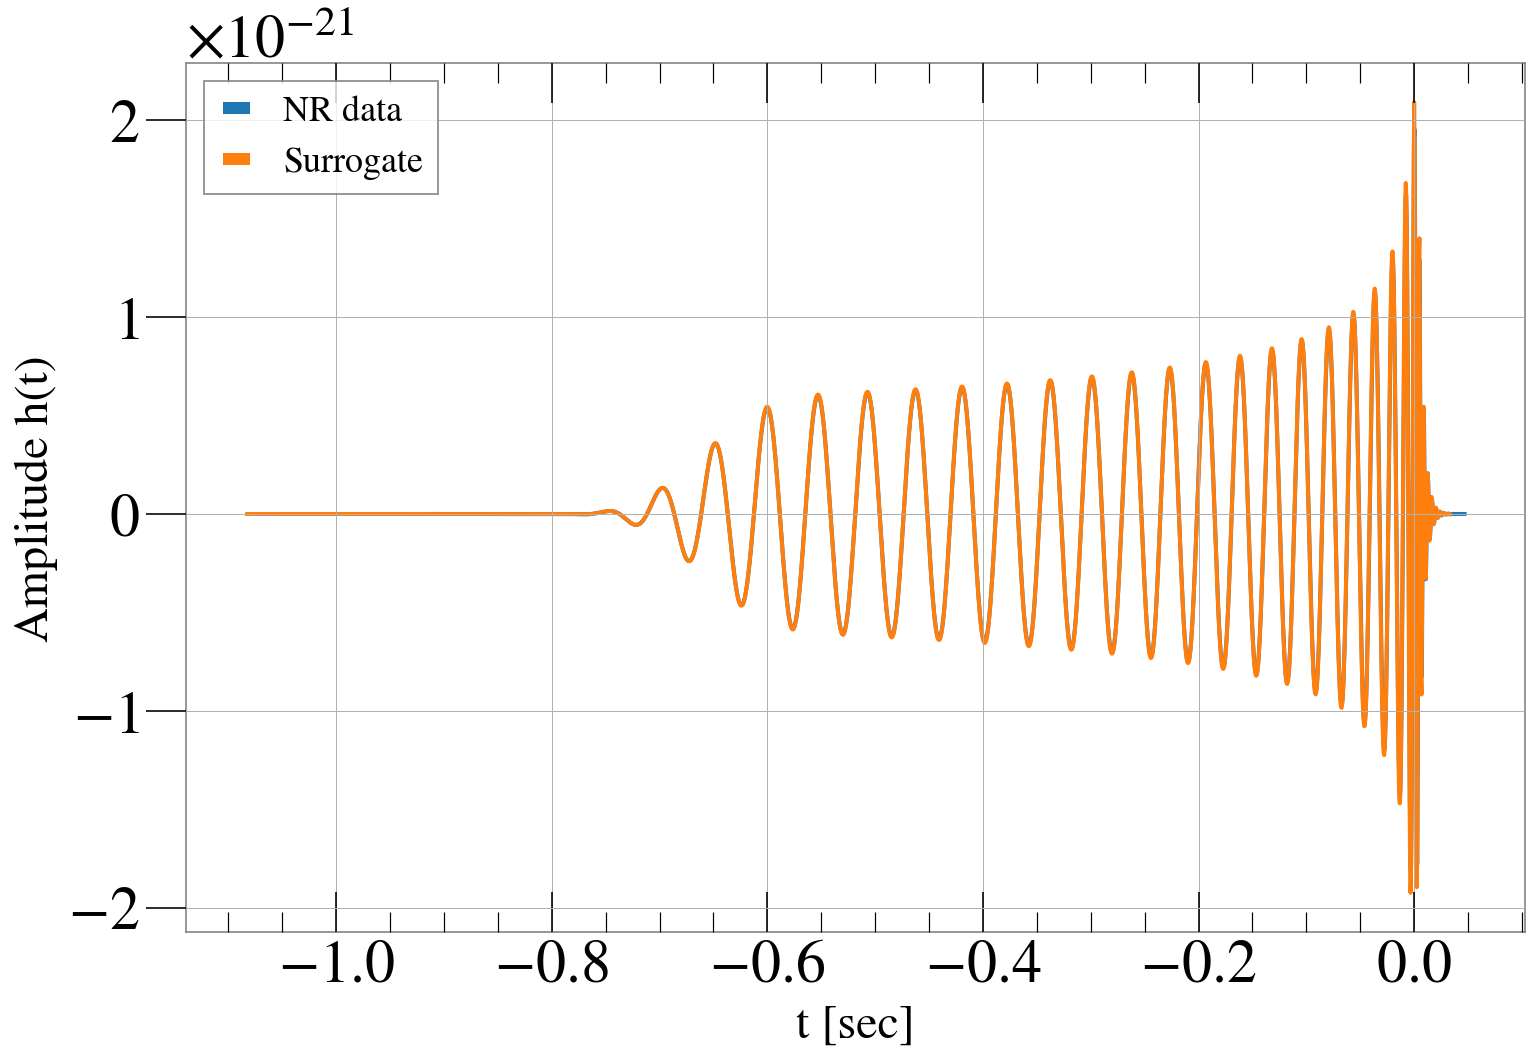

In [32]:
plt.figure(figsize=(12, 8))

plt.plot(time + 2e-4, h_plus, lw=2.0, label='NR data')

plt.plot(time_sur, h_plus_sur, '-', lw=2.0, label='Surrogate')

#plt.xlim(t_gps - 0.44, t_gps - 0.35)
#plt.xlim(-0.01, 0.01)
#print(t_gps)
#plt.ylim(1e-21, 3.5e-21)
plt.xlabel('t [sec]')
plt.ylabel('Amplitude h(t)')
plt.legend()
plt.show()

### Plot the frame files

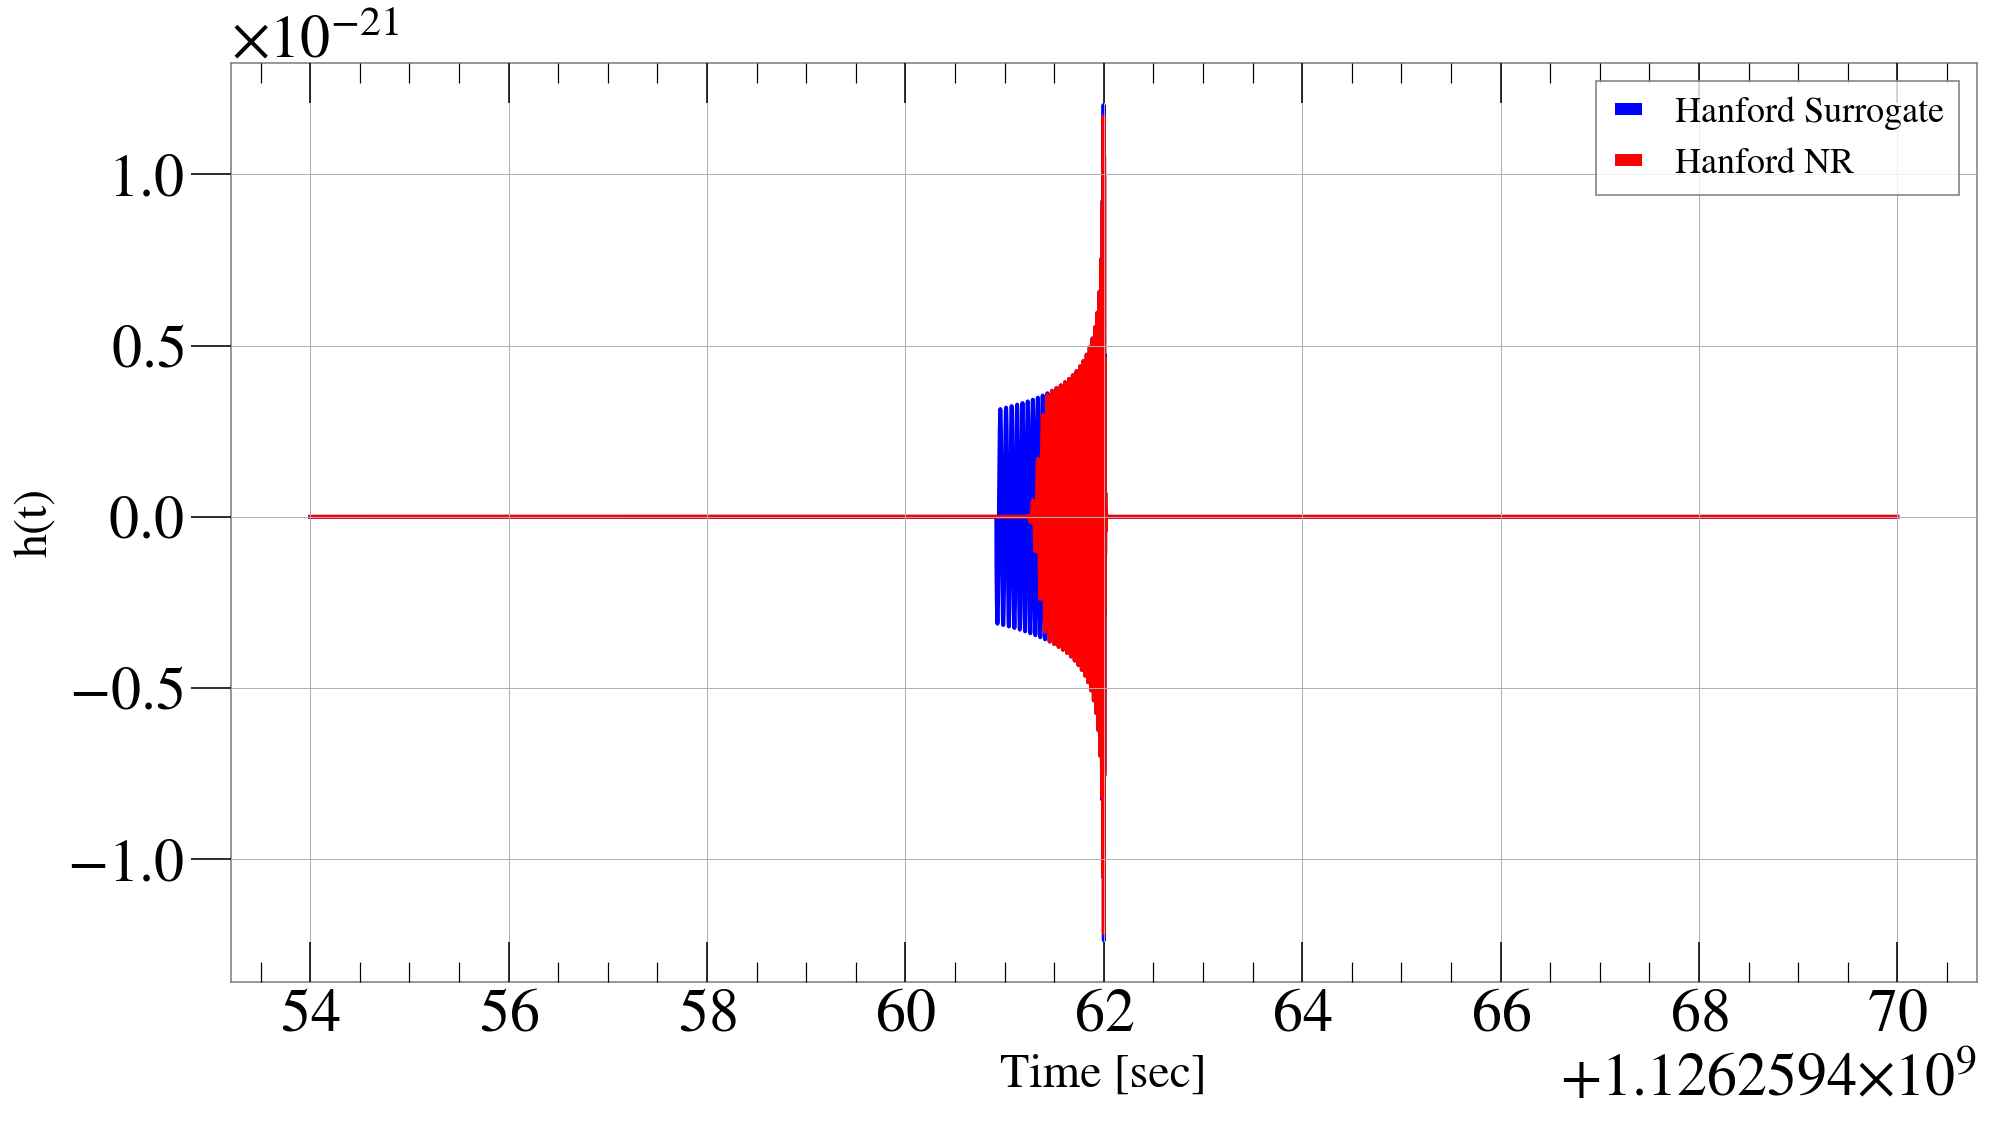

In [11]:
plt.figure(figsize=(14, 8))

def ReadStrains(my_dir):
    
    sH = TimeSeries.read(source = '/home/maria.okounkova/BeyondGRAnalysis/Frames/'+my_dir+'/'+my_dir+'_mtotal_68_dist_400/H-H1_HOFT-1126259454-16.gwf', channel="H1:LDAS_STRAIN")
    tH = sH.times

    sL = TimeSeries.read(source = '/home/maria.okounkova/BeyondGRAnalysis/Frames/'+my_dir+'/'+my_dir+'_mtotal_68_dist_400/L-L1_HOFT-1126259454-16.gwf', channel="L1:LDAS_STRAIN")
    tL = sL.times
    return tH, sH, tL, sL


tH_sur, sH_sur, tL_sur, sL_sur = ReadStrains("SurrogateTest")
tH, sH, tL, sL = ReadStrains("dCS_0p0")
#tH_22, sH_22, tL_22, sL_22 = ReadStrains("dCS_0p0_Lev3")

plt.plot(np.array(tH_sur), sH_sur, label='Hanford Surrogate', color='blue', lw=2.0)
plt.plot(np.array(tH) + 2e-4, sH, label='Hanford NR', color='red', lw=2.0)
#plt.plot(np.array(tH_22) - 2e-4, sH_22, label='Hanford NR Low res', lw=2.0)
#plt.plot(np.array(tL), sL, label='Livingston', color='red', lw=2.0)


plt.xlabel('Time [sec]')
plt.legend()
plt.ylabel('h(t)')
tt = 1126259462.4107006
#plt.xlim(tt - 0.45, tt -0.37)
        
plt.tight_layout()
plt.show()

## Plot frames files for dCS params

0.005239009857177734 s
14512
1126259462.0463867
0.005239009857177734 s
14512
1126259462.0463867
0.005239009857177734 s
14512
1126259462.0463867
0.005239009857177734 s
14510
1126259462.0463867


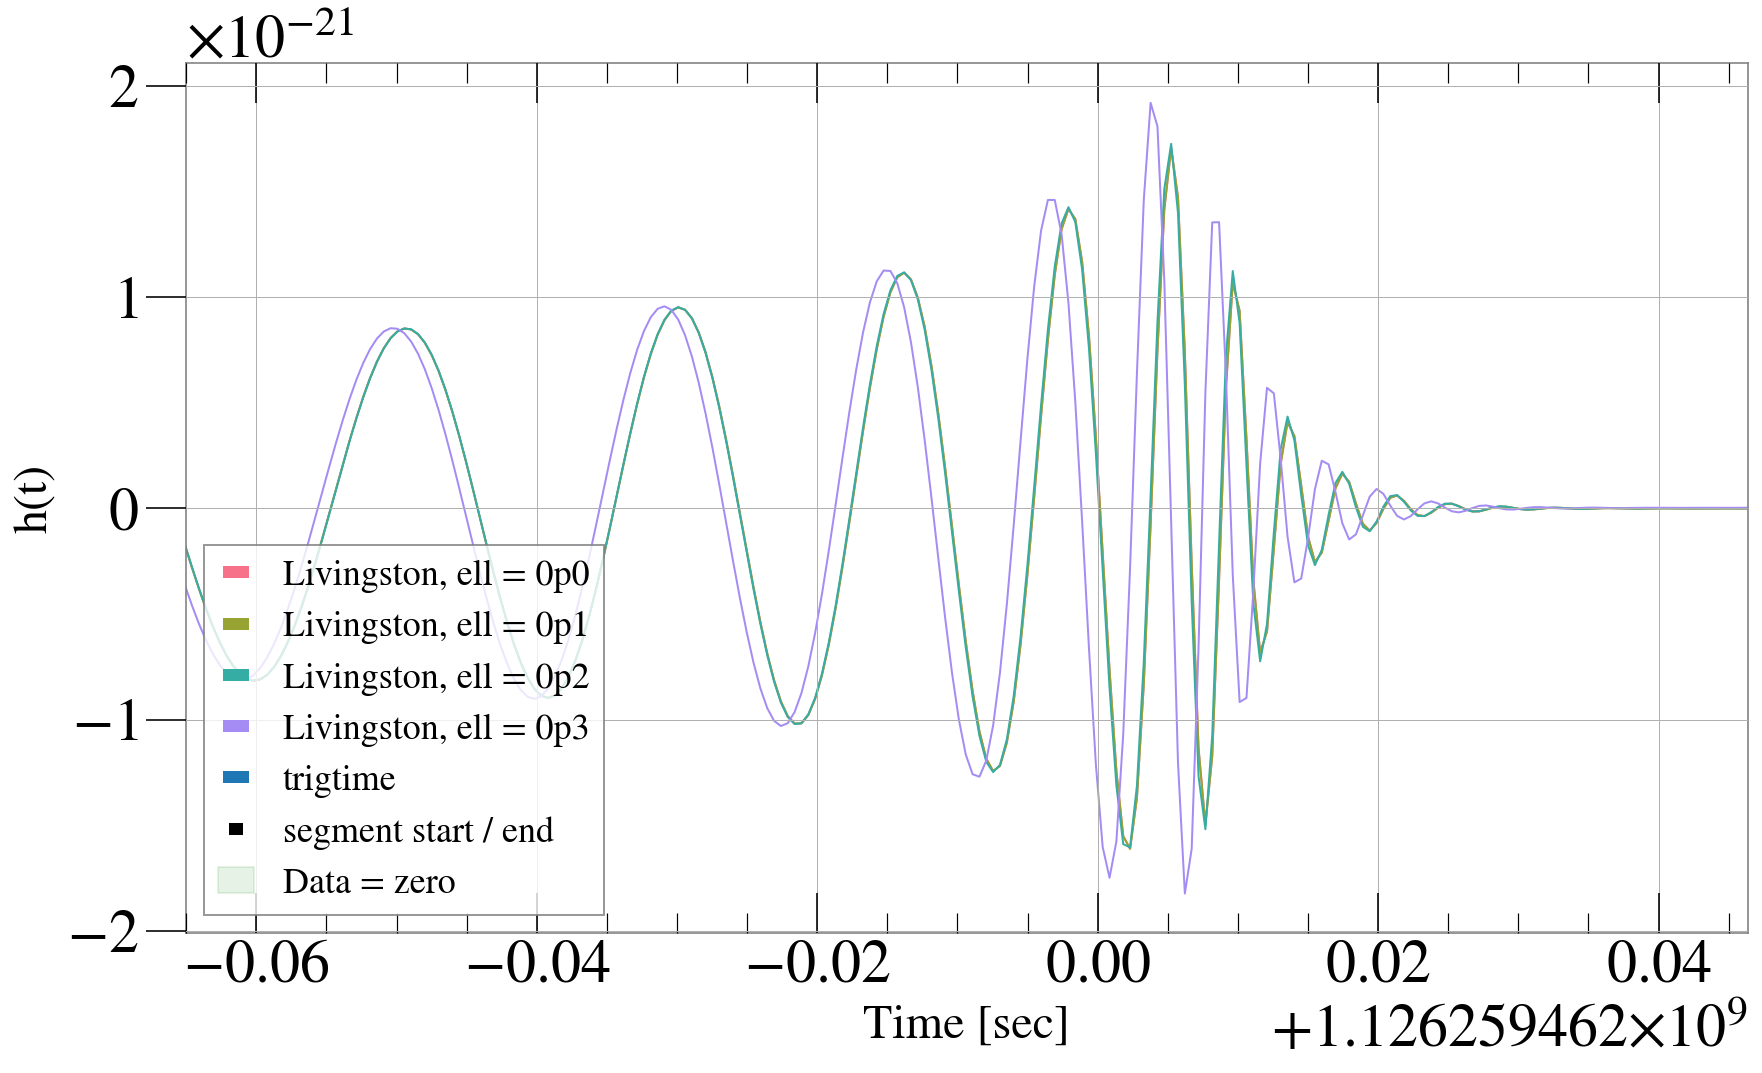

In [35]:
fig, ax = plt.subplots(figsize=(14, 8))

ells = ["0p0", "0p1", "0p2", "0p3"]
cs = sns.color_palette('husl', n_colors=len(ells))
for ell, color in zip(ells, cs):
    my_dir = "dCS_" + ell


    ## Livingston comes after hanford in this case
    sH = TimeSeries.read(source = '/home/maria.okounkova/BeyondGRAnalysis/Frames/'+my_dir+'/'+my_dir+'_mtotal_68_dist_400/H-H1_HOFT-1126259454-16.gwf', channel="H1:LDAS_STRAIN")
    tH = sH.times

    sL = TimeSeries.read(source = '/home/maria.okounkova/BeyondGRAnalysis/Frames/'+my_dir+'/'+my_dir+'_mtotal_68_dist_400/L-L1_HOFT-1126259454-16.gwf', channel="L1:LDAS_STRAIN")
    tL = sL.times
    
    ## Livingston comes after Hanford
    print(tL[-1] - tH[-1])
    
    ## Find where the data stops / starts being zero
    aa = np.array(np.where(sH == 0)[0])
    bb = aa[1:] - aa[:-1]
    start_index = np.where(bb != 1)[0][0]
    start = tH[start_index].value
    print(start_index)
    
    stop_index = 16479
    stop = tH[stop_index].value
    print(stop)
    #plt.plot(np.array(tH), sH, label='Hanford, ell = ' + ell, lw=1.0, color=color)
    plt.plot(np.array(tL), sL, '-', label='Livingston, ell = ' + ell, lw=1.0, color=color)

## Plot the trigtime for bayeswave
plt.axvspan(tH[0].value, start, label='Data = zero', color='green', alpha=0.1)
plt.axvspan(stop, tH[-1].value, color='green', alpha=0.1)
plt.axvline(1126259462.4107006, label='trigtime')
plt.axvline(1126259456.4107006, ls = '--', label='segment start / end', color='black')
plt.axvline(1126259456.4107006 + 8.0, ls = '--', color='black')
plt.xlabel('Time [sec]')
plt.xlim(start + 0.85, stop)
plt.legend(loc='lower left')
plt.ylabel('h(t)')
#tt = 1126259462.4107006
#plt.xlim(tt - 1.4, tt -0.2)
#plt.xlim(tt - 0.5, tt -0.37)      I 
# plt.tight_layout()
plt.show()